In [1]:
import sys
sys.executable


'C:\\Users\\Kartikey Soni\\.conda\\envs\\SIP_Project_env\\python.exe'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.tsatools import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [3]:
df = pd.read_csv("Refined_DaliyDelhiClimateData.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()

In [4]:
print(df.isnull().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [5]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


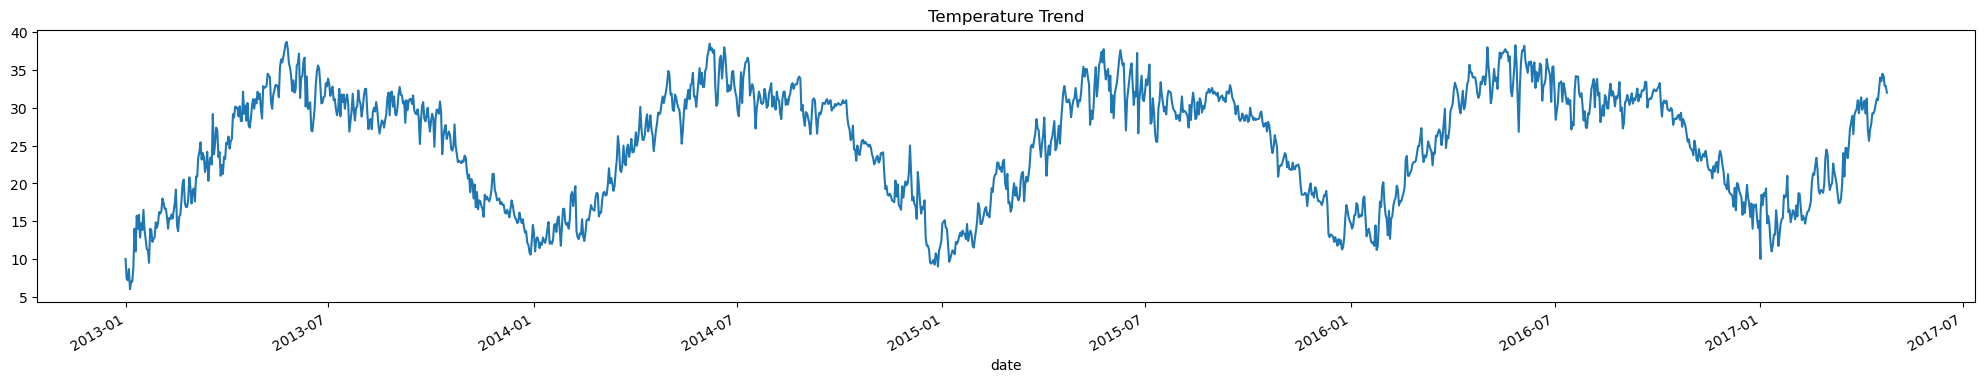

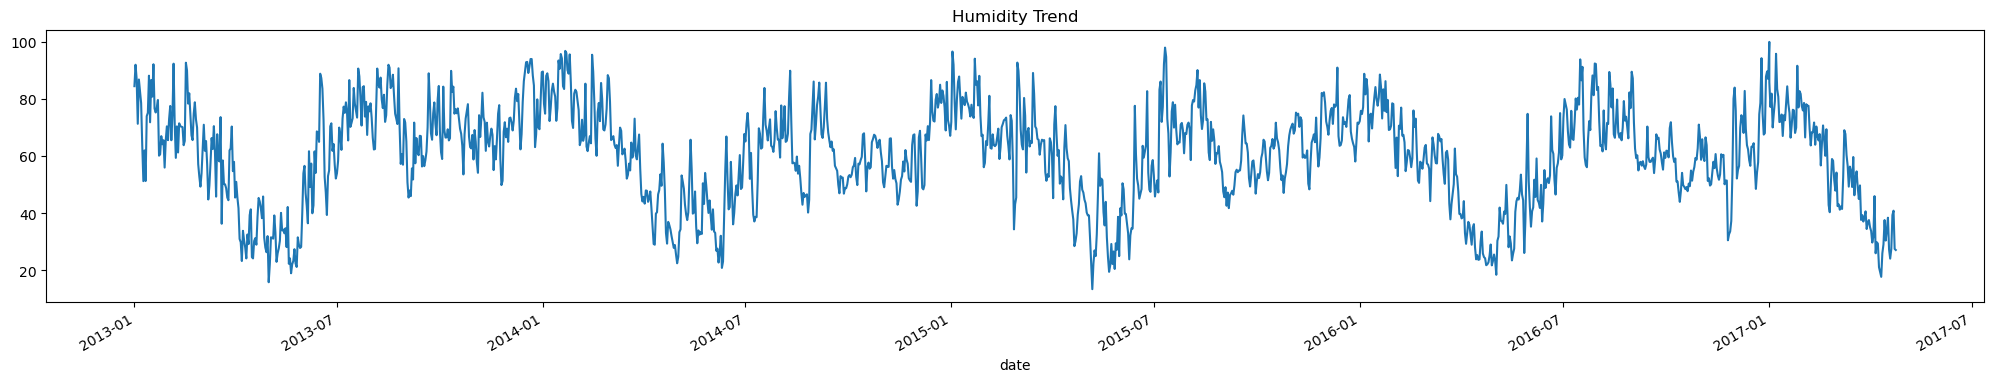

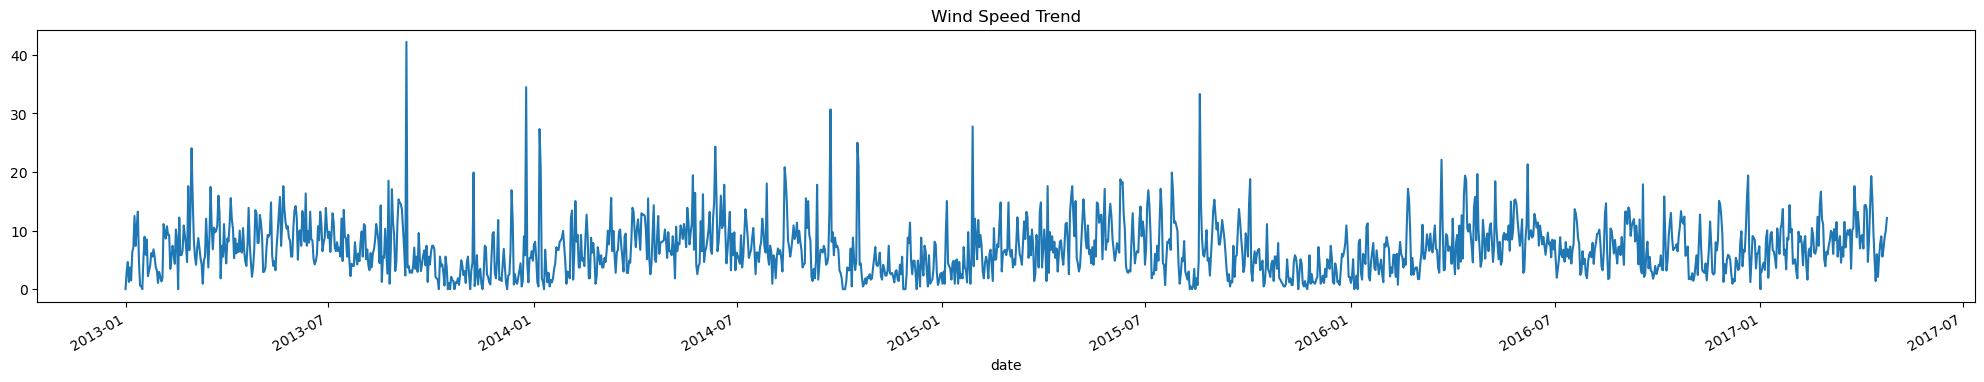

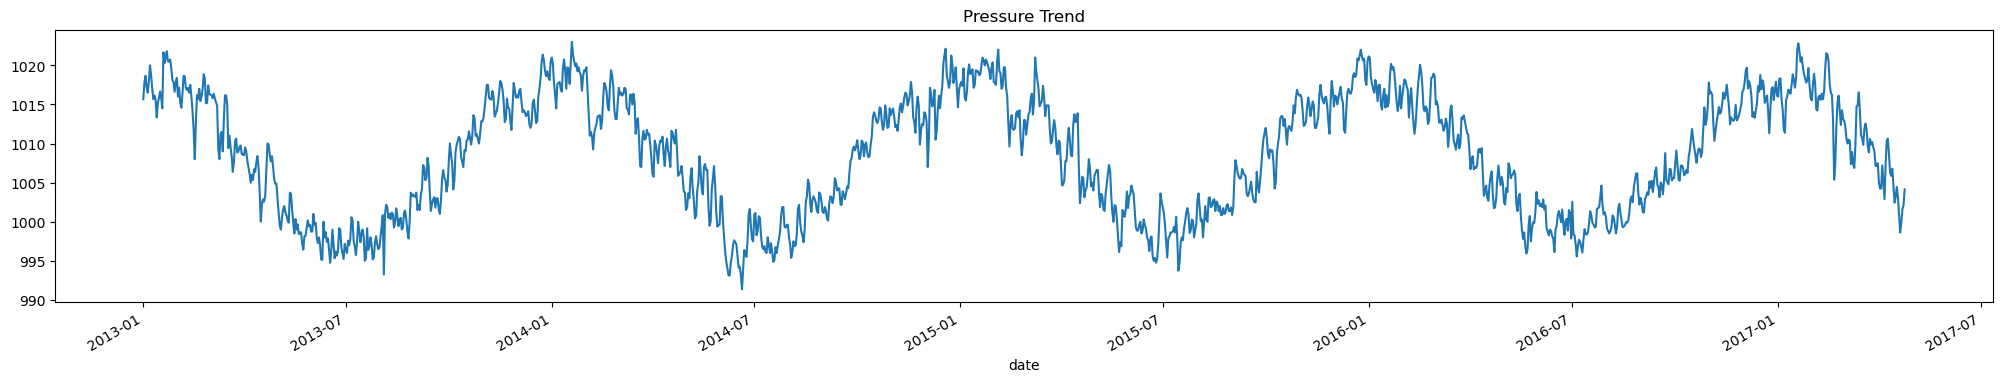

In [6]:
df['meantemp'].plot(figsize=(25,4), title = "Temperature Trend")
plt.show()

df['humidity'].plot(figsize=(25,4), title="Humidity Trend")
plt.show()

df['wind_speed'].plot(figsize=(25,4), title="Wind Speed Trend")
plt.show()

df['meanpressure'].plot(figsize=(25,4), title="Pressure Trend")
plt.show()

In [7]:
df['temp_lag1'] = df['meantemp'].shift(1)
df['temp_lag7'] = df['meantemp'].shift(7)
df['temp_rolling7'] = df['meantemp'].rolling(7).mean()
df['temp_rolling30'] = df['meantemp'].rolling(30).mean()

In [8]:
print(df.head())
print(df.info())

             meantemp   humidity  wind_speed  meanpressure  temp_lag1  \
date                                                                    
2013-01-01  10.000000  84.500000    0.000000   1015.666667        NaN   
2013-01-02   7.400000  92.000000    2.980000   1017.800000  10.000000   
2013-01-03   7.166667  87.000000    4.633333   1018.666667   7.400000   
2013-01-04   8.666667  71.333333    1.233333   1017.166667   7.166667   
2013-01-05   6.000000  86.833333    3.700000   1016.500000   8.666667   

            temp_lag7  temp_rolling7  temp_rolling30  
date                                                  
2013-01-01        NaN            NaN             NaN  
2013-01-02        NaN            NaN             NaN  
2013-01-03        NaN            NaN             NaN  
2013-01-04        NaN            NaN             NaN  
2013-01-05        NaN            NaN             NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data column

In [9]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

meantemp          0
humidity          0
wind_speed        0
meanpressure      0
temp_lag1         0
temp_lag7         0
temp_rolling7     0
temp_rolling30    0
dtype: int64
(1547, 8)


In [10]:
X = df[['humidity', 'wind_speed', 'meanpressure',
        'temp_lag1', 'temp_lag7', 'temp_rolling7', 'temp_rolling30']]

y = df['meantemp']

# SVR MODEL

In [11]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


MAE: 1.2945947521579684
RMSE: 1.6767459519501204
R2: 0.9340390585712707


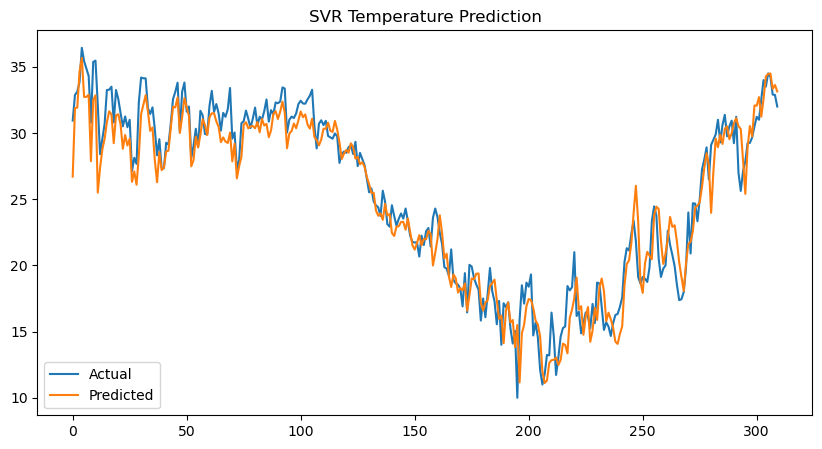

In [12]:
split = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]





from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr.fit(X_train, y_train.ravel())





y_pred_scaled = svr.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_actual = scaler_y.inverse_transform(y_test)




from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test_actual, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred)))
print("R2:", r2_score(y_test_actual, y_pred))




import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("SVR Temperature Prediction")
plt.show()


# TUNED SVR

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'C': [1, 10, 50, 100, 200],
    'gamma': ['scale', 0.01, 0.05, 0.1],
    'epsilon': [0.01, 0.05, 0.1, 0.2]
}


tscv = TimeSeriesSplit(n_splits=5)


svr = SVR(kernel='rbf')

grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train.ravel())

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 50, 'epsilon': 0.01, 'gamma': 0.01}


Tuned MAE: 1.1029721183001338
Tuned RMSE: 1.3934019951299381
Tuned R2: 0.9544482392774052


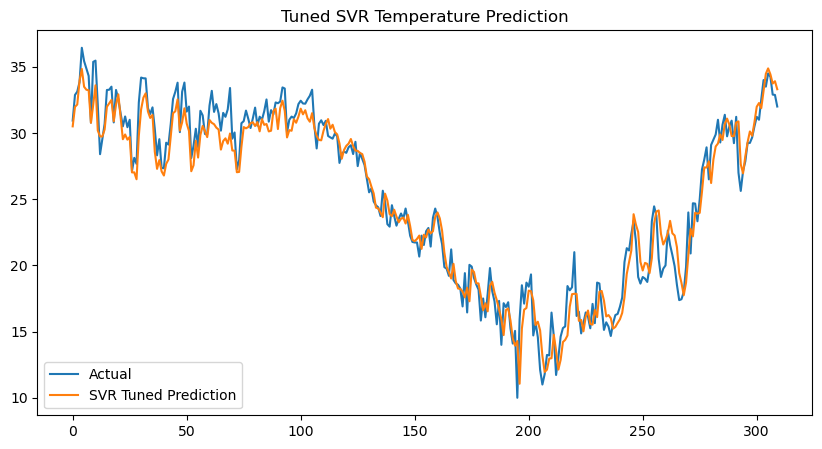

In [14]:
best_svr = grid_search.best_estimator_
best_svr.fit(X_train, y_train.ravel())

y_pred_scaled = best_svr.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_actual = scaler_y.inverse_transform(y_test)




from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Tuned MAE:", mean_absolute_error(y_test_actual, y_pred))
print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred)))
print("Tuned R2:", r2_score(y_test_actual, y_pred))




import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred, label="SVR Tuned Prediction")
plt.legend()
plt.title("Tuned SVR Temperature Prediction")
plt.show()


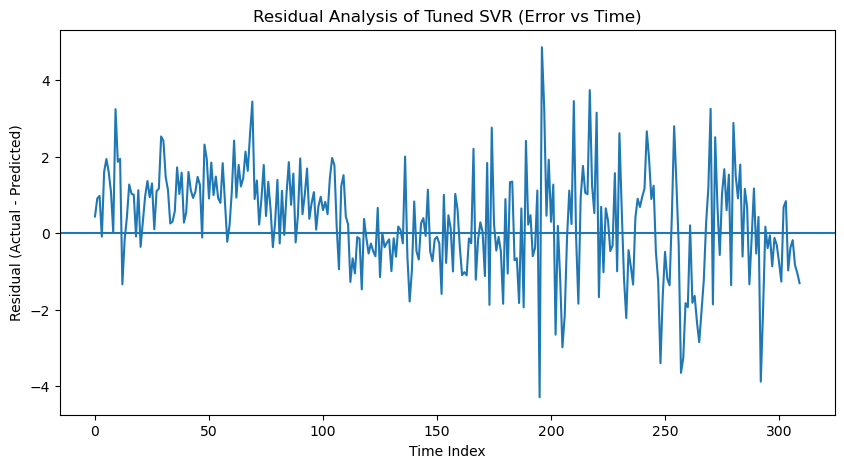

In [15]:
residuals = y_test_actual.flatten() - y_pred.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.axhline(0)  # zero reference line
plt.title("Residual Analysis of Tuned SVR (Error vs Time)")
plt.xlabel("Time Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()


# Linear Regression

Linear Regression MAE: 1.0974919207083633
Linear Regression RMSE: 1.3983312496866394
Linear Regression R2: 0.9541253843066295


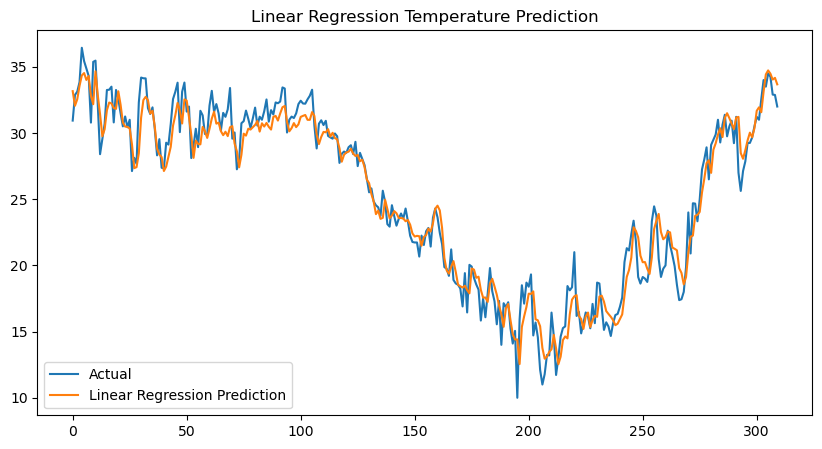

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X = df[['humidity', 'wind_speed', 'meanpressure',
        'temp_lag1', 'temp_lag7', 'temp_rolling7', 'temp_rolling30']]

y = df['meantemp']


split = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]





scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))



lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)


y_pred_scaled = lr.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)



lr_mae = mean_absolute_error(y_test_actual, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
lr_r2 = r2_score(y_test_actual, y_pred)

print("Linear Regression MAE:", lr_mae)
print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression R2:", lr_r2)



plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred, label="Linear Regression Prediction")
plt.legend()
plt.title("Linear Regression Temperature Prediction")
plt.show()


# Residual Analysis

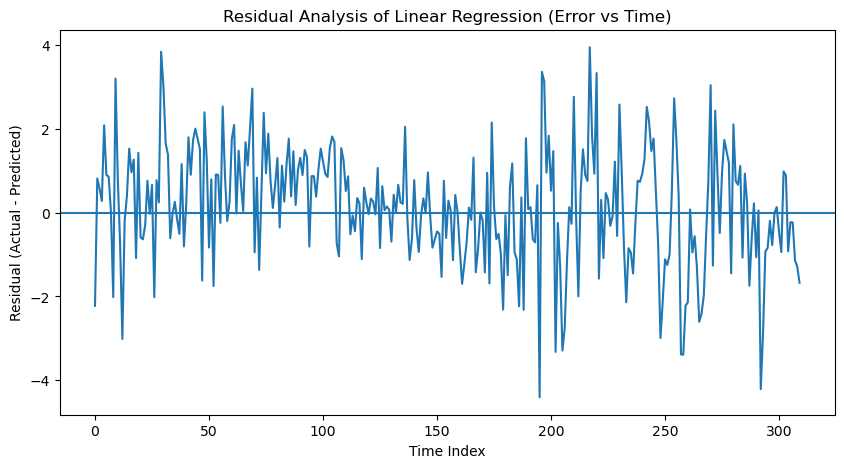

In [17]:
residuals = y_test_actual.flatten() - y_pred.flatten()


plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.axhline(0)  # zero reference line
plt.title("Residual Analysis of Linear Regression (Error vs Time)")
plt.xlabel("Time Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()


# LSTM

C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0334 - val_loss: 0.0049
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.

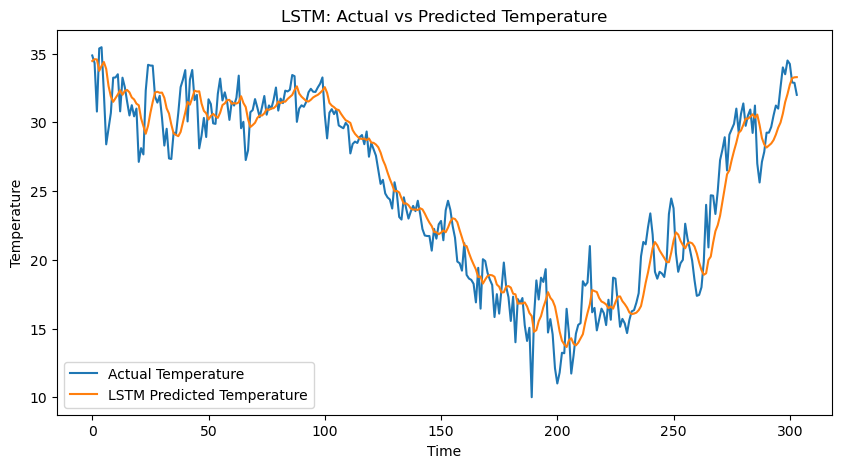

In [18]:
temp = df['meantemp'].values.reshape(-1,1)


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(temp)


import numpy as np

def create_sequences(data, step=30):
    X, y = [], []
    for i in range(len(data) - step):
        X.append(data[i:i+step])
        y.append(data[i+step])
    return np.array(X), np.array(y)

X, y = create_sequences(temp_scaled, 30)


split = int(len(X)*0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("LSTM RMSE:", rmse)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(y_pred, label='LSTM Predicted Temperature')
plt.legend()
plt.title("LSTM: Actual vs Predicted Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()


In [19]:
lr_mae = mean_absolute_error(y_test_actual, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
lr_r2 = r2_score(y_test_actual, y_pred)

print("LSTM MAE:", lr_mae)
print("LSTM RMSE:", lr_rmse)
print("LSTM R2:", lr_r2)

LSTM MAE: 1.530468165925307
LSTM RMSE: 1.922810240290987
LSTM R2: 0.9119169934068875


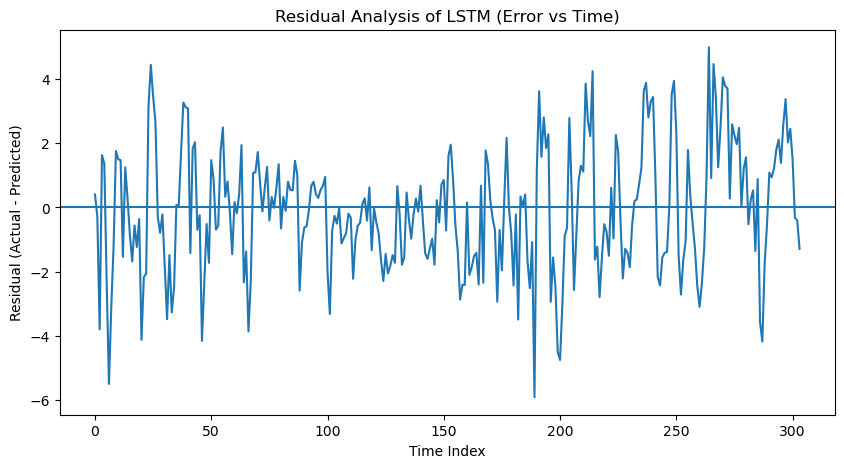

In [20]:
residuals = y_test_actual.flatten() - y_pred.flatten()


plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.axhline(0)  
plt.title("Residual Analysis of LSTM (Error vs Time)")
plt.xlabel("Time Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()